In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt
import copy

import random

from numpy import linalg as LA
from tabulate import tabulate
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
gamma = 0.04
gamma

0.04

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
fg_used = '012'
fg1, fg2, fg3 = 0,1,2


all_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
background_classes = all_classes - foreground_classes
background_classes

# print(type(foreground_classes))

{'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


In [ ]:
dataiter = iter(trainloader)
true_train_background_data=[]
true_train_background_label=[]
true_train_foreground_data=[]
true_train_foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      true_train_background_data.append(img)
      true_train_background_label.append(labels[j])
    else:
      img = images[j].tolist()
      true_train_foreground_data.append(img)
      true_train_foreground_label.append(labels[j])
            
true_train_foreground_data = torch.tensor(true_train_foreground_data)
true_train_foreground_label = torch.tensor(true_train_foreground_label)
true_train_background_data = torch.tensor(true_train_background_data)
true_train_background_label = torch.tensor(true_train_background_label)
    

In [ ]:
len(true_train_foreground_data), len(true_train_foreground_label), len(true_train_background_data), len(true_train_background_label)

(15000, 15000, 35000, 35000)

In [ ]:
dataiter = iter(testloader)
true_test_background_data=[]
true_test_background_label=[]
true_test_foreground_data=[]
true_test_foreground_label=[]
batch_size=10

for i in range(1000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      true_test_background_data.append(img)
      true_test_background_label.append(labels[j])
    else:
      img = images[j].tolist()
      true_test_foreground_data.append(img)
      true_test_foreground_label.append(labels[j])
            
true_test_foreground_data = torch.tensor(true_test_foreground_data)
true_test_foreground_label = torch.tensor(true_test_foreground_label)
true_test_background_data = torch.tensor(true_test_background_data)
true_test_background_label = torch.tensor(true_test_background_label)

In [ ]:
len(true_test_foreground_data), len(true_test_foreground_label), len(true_test_background_data), len(true_test_background_label)

(3000, 3000, 7000, 7000)

In [ ]:
true_train = trainset.data

In [ ]:
train_label = trainset.targets

In [ ]:
true_train_cifar_norm=[]
for i in range(len(true_train)):
  true_train_cifar_norm.append(LA.norm(true_train[i]))

In [ ]:
len(true_train_cifar_norm)

50000

In [ ]:
def plot_hist(values):
  plt.hist(values, density=True, bins=200)  # `density=False` would make counts
  plt.ylabel('NORM')
  plt.xlabel('Data');

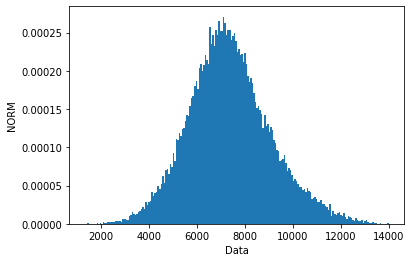

In [ ]:
plot_hist(true_train_cifar_norm)

In [ ]:
true_train.shape

(50000, 32, 32, 3)

In [ ]:
train = np.reshape(true_train, (50000,3072))
train.shape, true_train.shape

((50000, 3072), (50000, 32, 32, 3))

In [ ]:
u, s, vh = LA.svd(train, full_matrices= False)

In [ ]:
u.shape , s.shape, vh.shape

((50000, 3072), (3072,), (3072, 3072))

In [ ]:
s

array([1.55289927e+06, 2.82437414e+05, 2.17772149e+05, ...,
       7.31736954e+01, 7.23349722e+01, 7.18349192e+01])

In [ ]:
vh

array([[-0.01984194, -0.02066161, -0.02037075, ..., -0.01879724,
        -0.01874038, -0.01729938],
       [-0.02488245, -0.02705999, -0.03195926, ...,  0.01262528,
         0.01096339,  0.00766722],
       [-0.0159231 , -0.01437591, -0.01281541, ..., -0.02971411,
        -0.0283376 , -0.02749635],
       ...,
       [-0.00449998,  0.00770844, -0.00281931, ..., -0.00013103,
        -0.00080887,  0.00071151],
       [ 0.00433324, -0.00629207,  0.00181791, ..., -0.00168695,
         0.00131196,  0.00052667],
       [-0.00574169,  0.00783184, -0.00186197, ...,  0.00511688,
        -0.00678068,  0.00138508]])

In [ ]:
dir = vh[3062:3072,:]
dir

array([[ 0.00256167, -0.00421648,  0.00171443, ..., -0.00214198,
         0.0024008 , -0.00026442],
       [ 0.00629867, -0.01114679,  0.00518054, ..., -0.00382077,
         0.00504342, -0.00113716],
       [-0.0022958 ,  0.0006672 ,  0.00141218, ..., -0.00062172,
         0.00201576, -0.00146441],
       ...,
       [-0.00449998,  0.00770844, -0.00281931, ..., -0.00013103,
        -0.00080887,  0.00071151],
       [ 0.00433324, -0.00629207,  0.00181791, ..., -0.00168695,
         0.00131196,  0.00052667],
       [-0.00574169,  0.00783184, -0.00186197, ...,  0.00511688,
        -0.00678068,  0.00138508]])

In [ ]:
u1 = dir[7,:]
u2 = dir[8,:]
u3 = dir[9,:]

In [ ]:
u1

array([-0.00449998,  0.00770844, -0.00281931, ..., -0.00013103,
       -0.00080887,  0.00071151])

In [ ]:
u2

array([ 0.00433324, -0.00629207,  0.00181791, ..., -0.00168695,
        0.00131196,  0.00052667])

In [ ]:
u3

array([-0.00574169,  0.00783184, -0.00186197, ...,  0.00511688,
       -0.00678068,  0.00138508])

In [ ]:
len(train_label)

50000

In [ ]:
def is_equal(x1, x2):
  cnt=0
  for i in range(len(x1)):
    if(x1[i] == x2[i]):
      cnt+=1
  return cnt

In [ ]:
def add_noise_cifar(train, label, gamma, fg1,fg2,fg3):
  cnt=0

  for i in range(len(label)):
    x = train[i]
    if(label[i] == fg1):
      train[i] = train[i] + gamma * LA.norm(train[i]) * u1
      cnt+=1

    if(label[i] == fg2):
      train[i] = train[i] + gamma * LA.norm(train[i]) * u2
      cnt+=1

    if(label[i] == fg3):
      train[i] = train[i] + gamma * LA.norm(train[i]) * u3
      cnt+=1
    y = train[i]

  print("total modified",cnt)

  return train

total modified 15000
remain same 35000


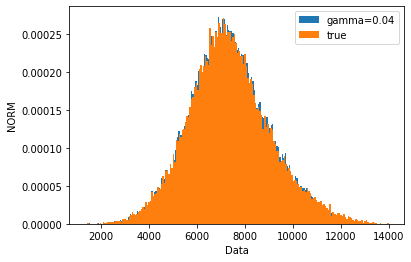

In [ ]:
noise_train = np.reshape(true_train, (50000,3072))
noise_train = add_noise_cifar(noise_train, train_label, gamma , fg1,fg2,fg3)
noise_train_cifar_norm=[]
for i in range(len(noise_train)):
  noise_train_cifar_norm.append(LA.norm(noise_train[i]))
plt.hist(noise_train_cifar_norm, density=True, bins=200,label='gamma='+str(gamma))  # `density=False` would make counts
plt.hist(true_train_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()
print("remain same",is_equal(noise_train_cifar_norm,true_train_cifar_norm))

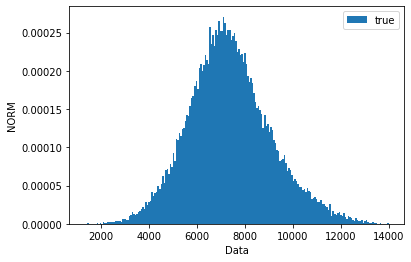

In [ ]:
plt.hist(true_train_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()

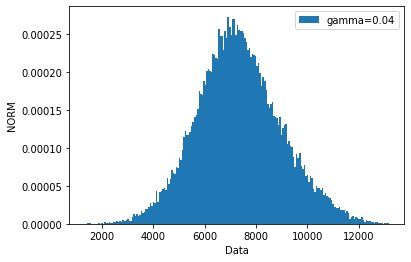

In [ ]:
plt.hist(noise_train_cifar_norm, density=True, bins=200,label='gamma='+str(gamma))  # `density=False` would make counts
# plt.hist(true_train_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()

In [ ]:
noise_train.shape, trainset.data.shape

((50000, 3072), (50000, 32, 32, 3))

In [ ]:
noise_train = np.reshape(noise_train, (50000,32, 32, 3))
noise_train.shape

(50000, 32, 32, 3)

In [ ]:
trainset.data = noise_train

In [ ]:
true_test = testset.data

In [ ]:
test_label = testset.targets

In [ ]:
true_test.shape

(10000, 32, 32, 3)

In [ ]:
test = np.reshape(true_test, (10000,3072))
test.shape

(10000, 3072)

In [ ]:
len(test_label)

10000

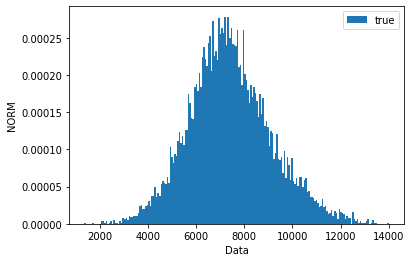

In [ ]:
true_test_cifar_norm=[]
for i in range(len(test)):
  true_test_cifar_norm.append(LA.norm(test[i]))

plt.hist(true_test_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()

total modified 3000


7000

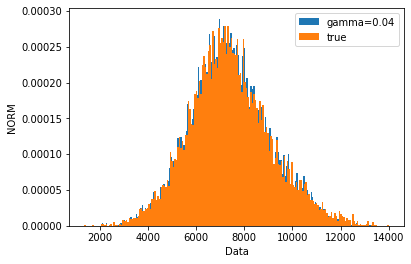

In [ ]:
noise_test = np.reshape(true_test, (10000,3072))
noise_test = add_noise_cifar(noise_test, test_label, gamma , fg1,fg2,fg3)
noise_test_cifar_norm=[]
for i in range(len(noise_test)):
  noise_test_cifar_norm.append(LA.norm(noise_test[i]))
plt.hist(noise_test_cifar_norm, density=True, bins=200,label='gamma='+str(gamma))  # `density=False` would make counts
plt.hist(true_test_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()
is_equal(noise_test_cifar_norm,true_test_cifar_norm)

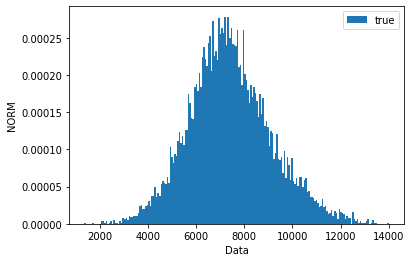

In [ ]:
plt.hist(true_test_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()

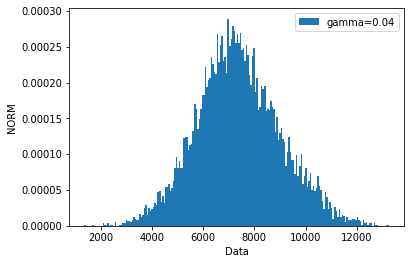

In [ ]:
plt.hist(noise_test_cifar_norm, density=True, bins=200,label='gamma='+str(gamma))  # `density=False` would make counts
# plt.hist(true_train_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()

In [ ]:
noise_test.shape, testset.data.shape

((10000, 3072), (10000, 32, 32, 3))

In [ ]:
noise_test = np.reshape(noise_test, (10000,32, 32, 3))
noise_test.shape

(10000, 32, 32, 3)

In [ ]:
testset.data = noise_test

In [ ]:
fg = [fg1,fg2,fg3]
bg = list(set([0,1,2,3,4,5,6,7,8,9])-set(fg))
fg,bg

([0, 1, 2], [3, 4, 5, 6, 7, 8, 9])

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


In [ ]:
dataiter = iter(trainloader)
train_background_data=[]
train_background_label=[]
train_foreground_data=[]
train_foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      train_background_data.append(img)
      train_background_label.append(labels[j])
    else:
      img = images[j].tolist()
      train_foreground_data.append(img)
      train_foreground_label.append(labels[j])

train_foreground_data = torch.tensor(train_foreground_data)
train_foreground_label = torch.tensor(train_foreground_label)
train_background_data = torch.tensor(train_background_data)
train_background_label = torch.tensor(train_background_label)    

In [ ]:
dataiter = iter(testloader)
test_background_data=[]
test_background_label=[]
test_foreground_data=[]
test_foreground_label=[]
batch_size=10

for i in range(1000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      test_background_data.append(img)
      test_background_label.append(labels[j])
    else:
      img = images[j].tolist()
      test_foreground_data.append(img)
      test_foreground_label.append(labels[j])

test_foreground_data = torch.tensor(test_foreground_data)
test_foreground_label = torch.tensor(test_foreground_label)
test_background_data = torch.tensor(test_background_data)
test_background_label = torch.tensor(test_background_label)    

In [ ]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

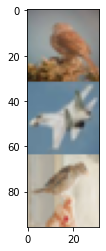

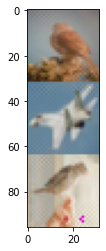

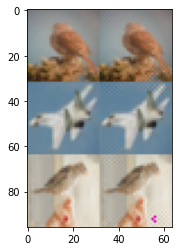

torch.Size([3, 96, 32])
15.613302 15.428806


In [ ]:
img1 = torch.cat((true_test_foreground_data[27],true_test_foreground_data[3],true_test_foreground_data[43]),1)
imshow(img1)
img2 = torch.cat((test_foreground_data[27],test_foreground_data[3],test_foreground_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())
print(LA.norm(test_foreground_data[27]), LA.norm(true_test_foreground_data[27]))

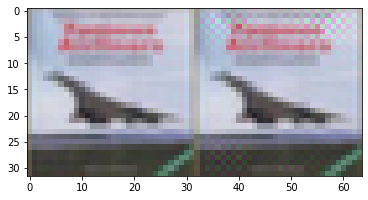

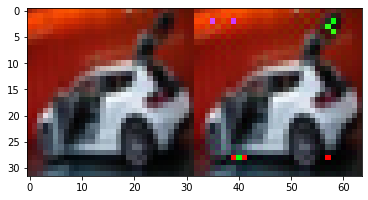

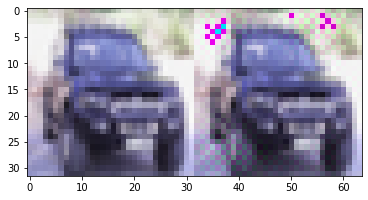

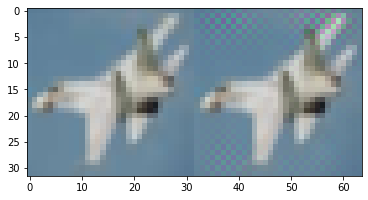

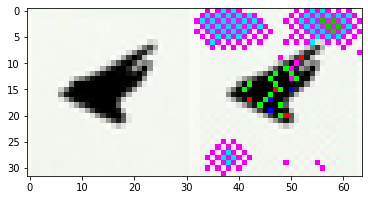

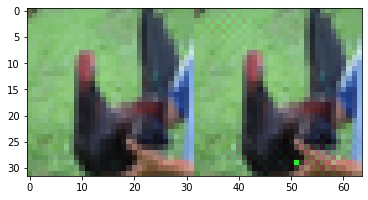

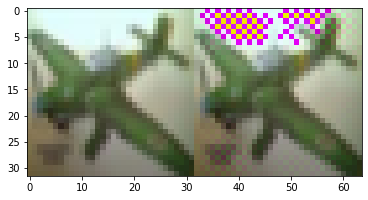

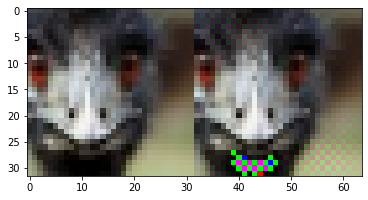

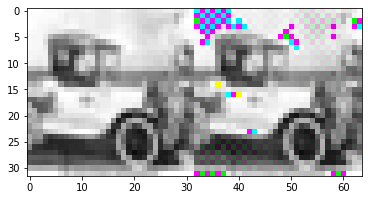

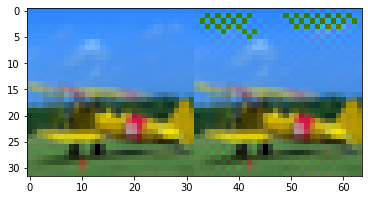

In [ ]:
import random
for i in range(10):
  random.seed(i)
  a = np.random.randint(0,10000)
  img1 = torch.cat((true_test_foreground_data[i],test_foreground_data[i]),2)
  imshow(img1)

In [ ]:
def plot_vectors(u1,u2,u3):
  img = np.reshape(u1,(3,32,32))
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  print("vector u1 norm",LA.norm(img))
  plt.figure(1)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title("vector u1")

  img = np.reshape(u2,(3,32,32))
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  print("vector u2 norm",LA.norm(img))
  plt.figure(2)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title("vector u2")

  img = np.reshape(u3,(3,32,32))
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  print("vector u3 norm",LA.norm(img))
  plt.figure(3)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title("vector u3")
  plt.show()

vector u1 norm 27.717323153497116
vector u2 norm 27.71732319535422
vector u3 norm 27.7173231446186


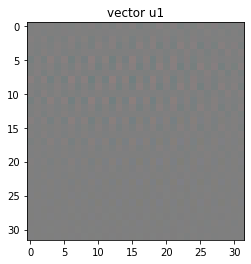

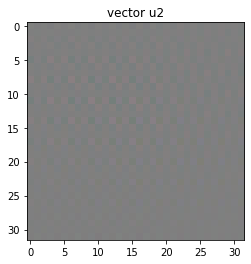

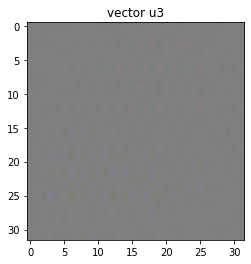

In [ ]:
plot_vectors(u1,u2,u3)

In [ ]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

In [ ]:
def create_mosaic_img(background_data, foreground_data, foreground_label, bg_idx,fg_idx,fg,fg1): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] -fg1  #-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [ ]:
def init_mosaic_creation(bg_size, fg_size, desired_num, background_data, foreground_data, foreground_label,fg1):
  # bg_size = 35000
  # fg_size = 15000
  # desired_num = 30000
  mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
  fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
  mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
  for i in range(desired_num):
    np.random.seed(i+ bg_size + desired_num)
    bg_idx = np.random.randint(0,bg_size,8)
    # print(bg_idx)
    np.random.seed(i+ fg_size + desired_num)
    fg_idx = np.random.randint(0,fg_size)
    # print(fg_idx)
    fg = np.random.randint(0,9)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(background_data, foreground_data, foreground_label ,bg_idx,fg_idx,fg, fg1)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)
  
  return mosaic_list_of_images, mosaic_label, fore_idx

In [ ]:
train_mosaic_list_of_images, train_mosaic_label, train_fore_idx = init_mosaic_creation(bg_size = 35000, 
                                                                     fg_size = 15000, 
                                                                     desired_num = 30000, 
                                                                     background_data = train_background_data, 
                                                                     foreground_data = train_foreground_data, 
                                                                     foreground_label = train_foreground_label,
                                                                     fg1 = fg1
                                                                     )

In [ ]:
batch = 250
msd_1 = MosaicDataset(train_mosaic_list_of_images, train_mosaic_label , train_fore_idx)
train_loader_from_noise_train_mosaic_30k = DataLoader( msd_1,batch_size= batch ,shuffle=True)

In [ ]:
test_mosaic_list_of_images, test_mosaic_label, test_fore_idx = init_mosaic_creation(bg_size = 35000, 
                                                                     fg_size = 15000, 
                                                                     desired_num = 10000, 
                                                                     background_data = train_background_data, 
                                                                     foreground_data = train_foreground_data, 
                                                                     foreground_label = train_foreground_label,
                                                                     fg1 = fg1
                                                                     )

In [ ]:
batch = 250
msd_2 = MosaicDataset(test_mosaic_list_of_images, test_mosaic_label , test_fore_idx)
test_loader_from_noise_train_mosaic_30k = DataLoader( msd_2, batch_size= batch ,shuffle=True)

In [ ]:
test_mosaic_list_of_images_1, test_mosaic_label_1, test_fore_idx_1 = init_mosaic_creation(bg_size = 7000, 
                                                                     fg_size = 3000, 
                                                                     desired_num = 10000, 
                                                                     background_data = test_background_data, 
                                                                     foreground_data = test_foreground_data, 
                                                                     foreground_label = test_foreground_label,
                                                                     fg1 = fg1
                                                                     )

In [ ]:
batch = 250
msd_3 = MosaicDataset(test_mosaic_list_of_images_1, test_mosaic_label_1 , test_fore_idx_1)
test_loader_from_noise_test_mosaic_10k = DataLoader( msd_3, batch_size= batch ,shuffle=True)

In [ ]:
test_mosaic_list_of_images_2, test_mosaic_label_2, test_fore_idx_2 = init_mosaic_creation(bg_size = 35000, 
                                                                     fg_size = 15000, 
                                                                     desired_num = 10000, 
                                                                     background_data = true_train_background_data, 
                                                                     foreground_data = true_train_foreground_data, 
                                                                     foreground_label = true_train_foreground_label,
                                                                     fg1 = fg1
                                                                     )

In [ ]:
batch = 250
msd_4 = MosaicDataset(test_mosaic_list_of_images_2, test_mosaic_label_2, test_fore_idx_2)
test_loader_from_true_train_mosaic_30k = DataLoader( msd_4, batch_size= batch , shuffle=True)

In [ ]:
test_mosaic_list_of_images_3, test_mosaic_label_3, test_fore_idx_3 = init_mosaic_creation(bg_size = 7000, 
                                                                     fg_size = 3000, 
                                                                     desired_num = 10000, 
                                                                     background_data = true_test_background_data, 
                                                                     foreground_data = true_test_foreground_data, 
                                                                     foreground_label = true_test_foreground_label,
                                                                     fg1 = fg1
                                                                     )

In [ ]:
batch = 250
msd_5 = MosaicDataset(test_mosaic_list_of_images_3, test_mosaic_label_3, test_fore_idx_3)
test_loader_from_true_train_mosaic_10k = DataLoader( msd_5, batch_size= batch ,shuffle=True)

In [ ]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [ ]:
def training(trainloader, fore_net, epochs=600):
  import torch.optim as optim
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
  nos_epochs = epochs

  for epoch in range(nos_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    cnt=0
    mini_loss = []
    iteration = 30000 // batch    
    for i, data in  enumerate(train_loader_from_noise_train_mosaic_30k):
      inputs , labels , fore_idx = data
      inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")

      optimizer.zero_grad()
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels) 
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      mini = 40    
      if cnt % mini == mini - 1:    # print every 40 mini-batches
        print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
        mini_loss.append(running_loss / mini)
        running_loss = 0.0        
      cnt=cnt+1
    if(np.average(mini_loss) <= 0.05):
      break
  print('Finished Training')
  return fore_net, epoch


In [ ]:
def testing(loader, fore_net):
  correct = 0
  total = 0
  count = 0
  flag = 1
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0

  argmax_more_than_half = 0
  argmax_less_than_half =0

  with torch.no_grad():
    for data in loader:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for j in range(labels.size(0)):
        count += 1
        focus = torch.argmax(alphas[j])
        if alphas[j][focus] >= 0.5 :
          argmax_more_than_half += 1
        else:
          argmax_less_than_half += 1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1
        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true += 1
        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false += 1
        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false += 1

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  return correct, total, focus_true_pred_true, focus_false_pred_true, focus_true_pred_false, focus_false_pred_false, argmax_more_than_half


In [ ]:
def enter_into(table, sno, correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half , fg, bg, epoch = "NA"):
  entry = []
  entry = [sno,'fg = '+ str(fg),'bg = '+str(bg), epoch, total, correct,]
  entry.append((100.0*correct/total))
  entry.append((100 * ftpt / total))
  entry.append( (100 * ffpt / total))
  entry.append( ( 100 * ftpf / total))
  entry.append( ( 100 * ffpf / total))
  entry.append( alpha_more_half)

  table.append(entry)
  print(" ")
  print("="*160)
  print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','Epoch used','total_points', 'correct','accuracy','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )
  print(" ")
  print("="*160)
  return table

In [ ]:
def add_average_entry(table):
  entry =[]
  entry = ['Avg', "","" ,"" ,"" , "",]
  entry.append( np.mean(np.array(table)[:,6].astype(np.float)) )
  entry.append( np.mean(np.array(table)[:,7].astype(np.float)) )
  entry.append( np.mean(np.array(table)[:,8].astype(np.float)) )
  entry.append( np.mean(np.array(table)[:,9].astype(np.float)) )
  entry.append( np.mean(np.array(table)[:,10].astype(np.float)) )
  entry.append( np.mean(np.array(table)[:,11].astype(np.float)) )

  table.append(entry)
  print(" ")
  print("="*160)
  print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','Epoch used','total_points', 'correct','accuracy','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )
  print(" ")
  print("="*160)
  return table


In [ ]:
train_table=[]
test_table1=[]
test_table2=[]
test_table3=[]
test_table4=[]
fg = [fg1,fg2,fg3]
bg = list(set([0,1,2,3,4,5,6,7,8,9])-set(fg))


In [78]:
number_runs = 10

for i in range(number_runs):
  fore_net = Module2().double()
  fore_net = fore_net.to("cuda")

  fore_net, epoch = training(train_loader_from_noise_train_mosaic_30k, fore_net)

  correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half = testing(train_loader_from_noise_train_mosaic_30k, fore_net)
  train_table = enter_into(train_table, i+1, correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half, fg, bg, str(epoch) )

  correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half = testing(test_loader_from_noise_train_mosaic_30k, fore_net)
  test_table1 = enter_into(test_table1, i+1, correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half , fg, bg )

  correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half = testing(test_loader_from_noise_test_mosaic_10k, fore_net)
  test_table2 = enter_into(test_table2, i+1, correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half, fg, bg )

  correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half = testing(test_loader_from_true_train_mosaic_30k, fore_net)
  test_table3 = enter_into(test_table3, i+1, correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half , fg, bg)

  correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half = testing(test_loader_from_true_train_mosaic_10k, fore_net)
  test_table4 = enter_into(test_table4, i+1, correct, total, ftpt, ffpt, ftpf, ffpf, alpha_more_half, fg, bg )



[1,    40] loss: 1.108
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.099
[2,    80] loss: 1.099
[2,   120] loss: 1.099
[3,    40] loss: 1.099
[3,    80] loss: 1.099
[3,   120] loss: 1.099
[4,    40] loss: 1.099
[4,    80] loss: 1.099
[4,   120] loss: 1.099
[5,    40] loss: 1.099
[5,    80] loss: 1.099
[5,   120] loss: 1.099
[6,    40] loss: 1.099
[6,    80] loss: 1.099
[6,   120] loss: 1.098
[7,    40] loss: 1.099
[7,    80] loss: 1.099
[7,   120] loss: 1.099
[8,    40] loss: 1.098
[8,    80] loss: 1.099
[8,   120] loss: 1.099
[9,    40] loss: 1.099
[9,    80] loss: 1.098
[9,   120] loss: 1.099
[10,    40] loss: 1.099
[10,    80] loss: 1.098
[10,   120] loss: 1.099
[11,    40] loss: 1.098
[11,    80] loss: 1.098
[11,   120] loss: 1.099
[12,    40] loss: 1.098
[12,    80] loss: 1.098
[12,   120] loss: 1.098
[13,    40] loss: 1.098
[13,    80] loss: 1.098
[13,   120] loss: 1.098
[14,    40] loss: 1.098
[14,    80] loss: 1.098
[14,   120] loss: 1.098
[15,    40] loss: 1

In [79]:
train_table = add_average_entry(train_table)

 
S.No.    fg_class        bg_class                    Epoch used    total_points    correct      accuracy     FTPT        FFPT       FTPF        FFPF    avg_img > 0.5
-------  --------------  --------------------------  ------------  --------------  ---------  ----------  -------  ----------  ---------  ----------  ---------------
1        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  39            30000           29614         98.7133  47.3167  51.3967     1.06667    0.22                 1077
2        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  30            30000           29793         99.31    85.15    14.16       0.686667   0.00333333          21038
3        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  22            30000           29695         98.9833  98.9567   0.0266667  1.01667    0                   29994
4        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  23            30000           29737         99.1233  35.1233  64          0.466667   0.41                    0
5        f

In [80]:
test_table1 = add_average_entry(test_table1)

 
S.No.    fg_class        bg_class                    Epoch used    total_points    correct      accuracy    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  ------------  --------------  ---------  ----------  ------  ------  ------  ------  ---------------
1        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9823           98.23   47.63   50.6     1.54    0.23             373
2        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9928           99.28   84.86   14.42    0.72    0               6961
3        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9880           98.8    98.76    0.04    1.2     0               9998
4        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9893           98.93   34.76   64.17    0.54    0.53               0
5        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000          

In [81]:
test_table2 = add_average_entry(test_table2)

 
S.No.    fg_class        bg_class                    Epoch used    total_points    correct      accuracy    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  ------------  --------------  ---------  ----------  ------  ------  ------  ------  ---------------
1        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9860           98.6    45.88   52.72    1.24     0.16            391
2        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9893           98.93   84.76   14.17    1.07     0              7008
3        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9862           98.62   98.58    0.04    1.38     0              9999
4        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           9883           98.83   34.18   64.65    0.83     0.34              0
5        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000          

In [82]:
test_table3 = add_average_entry(test_table3)

 
S.No.    fg_class        bg_class                    Epoch used    total_points    correct      accuracy    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  ------------  --------------  ---------  ----------  ------  ------  ------  ------  ---------------
1        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3231           32.31    2.65   29.66   21.15   46.54               0
2        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3255           32.55    3.86   28.69    3.23   64.22              81
3        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3286           32.86    4.18   28.68    9.87   57.27            3308
4        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3255           32.55    3.82   28.73   15.4    52.05               0
5        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000          

In [83]:
test_table4 = add_average_entry(test_table4)

 
S.No.    fg_class        bg_class                    Epoch used    total_points    correct      accuracy    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  ------------  --------------  ---------  ----------  ------  ------  ------  ------  ---------------
1        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3224           32.24    2.32    29.92   19.7   48.06               0
2        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3283           32.83    3.39    29.44    2.84  64.33              85
3        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3303           33.03    3.65    29.38    8.85  58.12            3288
4        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000           3283           32.83    3.55    29.28   15.29  51.88               0
5        fg = [0, 1, 2]  bg = [3, 4, 5, 6, 7, 8, 9]  NA            10000          

In [84]:
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/mosaic_from_CIFAR_involving_bottop_eigen_vectors/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")